# Dog or cat classification (ResNet50V2)

In [18]:
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import vgg19
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

## Загрузка и преобразование данных

In [19]:
import os
from random import shuffle
from glob import glob

IMG_SIZE = (224, 224)  # размер входного изображения сети
batch_size = 32

train_files = glob('data/train/*.jpg')
test_files = glob('data/test/*.jpg')

# загружаем входное изображение и предобрабатываем
def load_image(path, target_size=IMG_SIZE):
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, target_size)
    return vgg19.preprocess_input(img)  # предобработка для ResNet50V2


# функция-генератор загрузки обучающих данных с диска
def fit_generator(files, batch_size=batch_size):
    batch_size = min(batch_size, len(files))
    while True:
        shuffle(files)
        for k in range(len(files) // batch_size):
            i = k * batch_size
            j = i + batch_size
            if j > len(files):
                j = - j % len(files)
            x = np.array([load_image(path) for path in files[i:j]])
            y = np.array([1. if os.path.basename(path).startswith('dog') else 0.
                          for path in files[i:j]])
            yield (x, y)


# функция-генератор загрузки тестовых изображений с диска
def predict_generator(files):
    while True:
        for path in files:
            input_data = np.array([load_image(path)])
            yield (input_data,)

## Визуализация данных

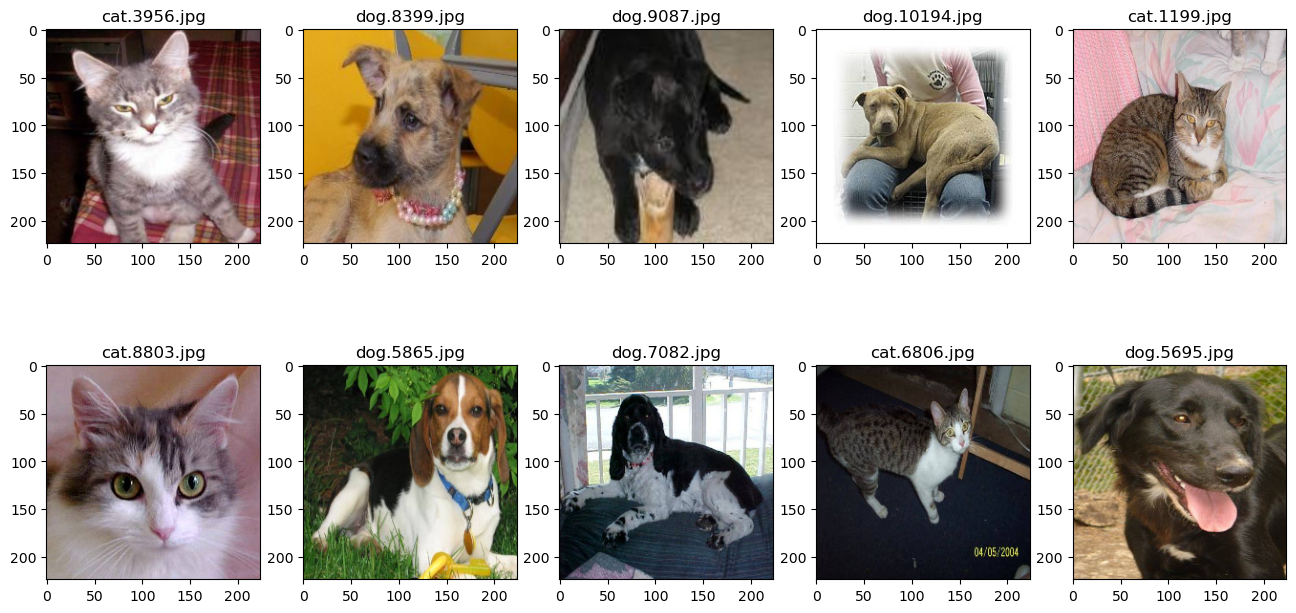

In [20]:
%matplotlib inline
from matplotlib import pyplot as plt
fig = plt.figure(figsize=(16, 8))
for i, path in enumerate(train_files[1000:1010], 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%s' % path.split('/')[-1])
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    plt.imshow(img)

## Загрузка предобученной модели

In [21]:
Resnet = vgg19.VGG19(weights="imagenet", include_top=False,
                    input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))

In [22]:
Resnet.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [42]:
for layer in Resnet.layers:
    layer.trainable = False

x = Resnet.layers[-6].output
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dense(256, activation="relu")(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.3)(x)
x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

dog_cat_model = tf.keras.Model(inputs=Resnet.input, outputs=x, name="cat_or_dog")

In [37]:
dog_cat_model.summary()

Model: "cat_or_dog"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0

In [43]:
dog_cat_model.compile(
    optimizer=Adam(1e-3), 
    loss='binary_crossentropy',  # функция потерь binary_crossentropy (log loss
    metrics=['accuracy']
)

In [44]:
val_samples = 2000 # число изображений в валидационной выборке

shuffle(train_files)  # перемешиваем обучающую выборку
validation_data = next(fit_generator(train_files[:val_samples], val_samples))
train_data = fit_generator(train_files[val_samples:])  # данные читаем функцией-генератором

# создаём раннюю остановку в случае переобучения
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
# запускаем процесс обучения 
dog_cat_model.fit(train_data,
          steps_per_epoch=20,  # число вызовов генератора за эпоху
          epochs=100,  # число эпох обучения
          validation_data=validation_data,
          callbacks=early_stopping)

Epoch 1/100


2024-09-08 20:12:21.499855: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


20/20 [==============================] - 157s 8s/step - loss: 24.4821 - accuracy: 0.6016 - val_loss: 4.6843 - val_accuracy: 0.7570
Epoch 2/100
20/20 [==============================] - 156s 8s/step - loss: 5.7413 - accuracy: 0.7375 - val_loss: 2.2070 - val_accuracy: 0.8045
Epoch 3/100
20/20 [==============================] - 156s 8s/step - loss: 5.1114 - accuracy: 0.7141 - val_loss: 2.0175 - val_accuracy: 0.7805
Epoch 4/100
20/20 [==============================] - 159s 8s/step - loss: 2.9910 - accuracy: 0.7328 - val_loss: 1.3304 - val_accuracy: 0.7930
Epoch 5/100
20/20 [==============================] - 157s 8s/step - loss: 1.4485 - accuracy: 0.7547 - val_loss: 0.6600 - val_accuracy: 0.8140
Epoch 6/100
20/20 [==============================] - 155s 8s/step - loss: 0.7960 - accuracy: 0.7922 - val_loss: 0.4873 - val_accuracy: 0.8195
Epoch 7/100
20/20 [==============================] - 156s 8s/step - loss: 0.5692 - accuracy: 0.8000 - val_loss: 0.4301 - val_accuracy: 0.8385
Epoch 8/100
20/20

In [45]:
dog_cat_model.save("dog_cat_resnet.hdf5")

## Делаем предсказния для тестовых данных

In [46]:
test_pred = dog_cat_model.predict(
    predict_generator(test_files), steps=len(test_files))

    2/12500 [..............................] - ETA: 14:45

2024-09-08 21:19:08.369627: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


12500/12500 [==============================] - 864s 69ms/step


/var/folders/04/r9r20vkj4ds6fs03s9q9t6th0000gn/T/ipykernel_1988/2648597163.py:4: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  subplot.set_title('%.2f %s' % (score, os.path.basename(path)))


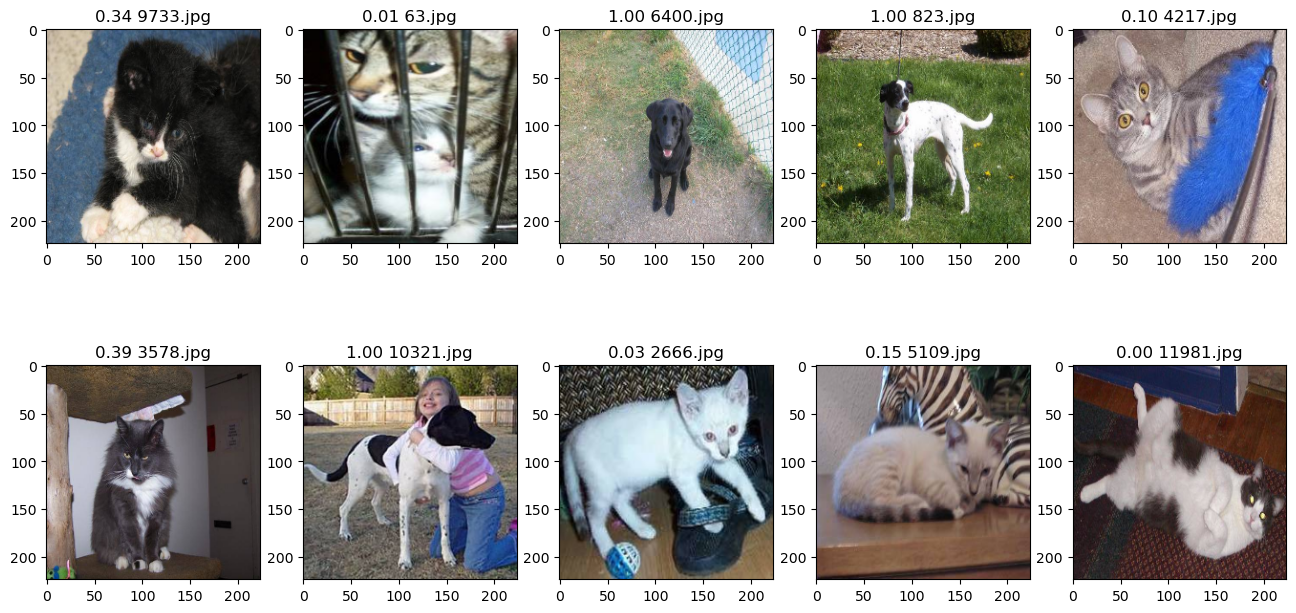

In [47]:
fig = plt.figure(figsize=(16, 8))
for i, (path, score) in enumerate(zip(test_files[:10], test_pred[:10]), 1):
    subplot = fig.add_subplot(2, 5, i)
    subplot.set_title('%.2f %s' % (score, os.path.basename(path)))
    img = cv2.imread(path)[...,::-1]
    img = cv2.resize(img, IMG_SIZE)
    subplot.imshow(img)

## Загрузка финальных ответов

In [48]:
import re

with open('submit.csv', 'w') as dst:
    dst.write('id,label\n')
    for path, score in zip(test_files, test_pred):
        dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))

/var/folders/04/r9r20vkj4ds6fs03s9q9t6th0000gn/T/ipykernel_1988/2367134345.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dst.write('%s,%f\n' % (re.search('(\d+).jpg$', path).group(1), score))
